In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import multivariate_normal

#Data

In [3]:
train = pd.read_json("/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/Data/UIT-VSFC-train.json", encoding="utf-8")
dev = pd.read_json("/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/Data/UIT-VSFC-dev.json", encoding="utf-8")
test = pd.read_json("/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/Data/UIT-VSFC-test.json", encoding="utf-8")

In [4]:
train.info(), dev.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11426 non-null  object
 1   sentiment  11426 non-null  object
 2   topic      11426 non-null  object
dtypes: object(3)
memory usage: 267.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   1583 non-null   object
 1   sentiment  1583 non-null   object
 2   topic      1583 non-null   object
dtypes: object(3)
memory usage: 37.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   3166 non-null   object
 1   sentiment  3166 non-null   object
 2   topic      3166 non-null   object
dtypes: obje

(None, None, None)

In [5]:
def visualize(data: object, col1: str, col2: str):
  fig, ax = plt.subplots(1, 2, figsize=(9, 5), dpi=125)


  sns.countplot(ax=ax[0], data=data, x=col1, order=train[col1].value_counts().index, palette='Set2')
  ax[0].set_title(f"Count on {col1}")
  ax[0].set_xlabel("Type")
  ax[0].set_ylabel("Count")
  ax[0].tick_params(axis='x', rotation=45)

  sns.countplot(ax=ax[1], data=data, x=col2, order=data[col2].value_counts().index, palette='Set2')
  ax[1].set_title(f"Count on sentiment {col2}")
  ax[1].set_xlabel("Type")
  ax[1].set_ylabel("Count")
  ax[1].tick_params(axis='x', rotation=45)

  for ax_i in ax:
      for p in ax_i.patches:
          height = p.get_height()
          if height > 0:
              ax_i.annotate(f'{int(height)}',
                            (p.get_x() + p.get_width() / 2, height + 1),
                            ha='center', va='bottom', fontsize=9)

Train

<ipython-input-5-8506a5c4b228>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax[0], data=data, x=col1, order=train[col1].value_counts().index, palette='Set2')
<ipython-input-5-8506a5c4b228>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax[1], data=data, x=col2, order=data[col2].value_counts().index, palette='Set2')


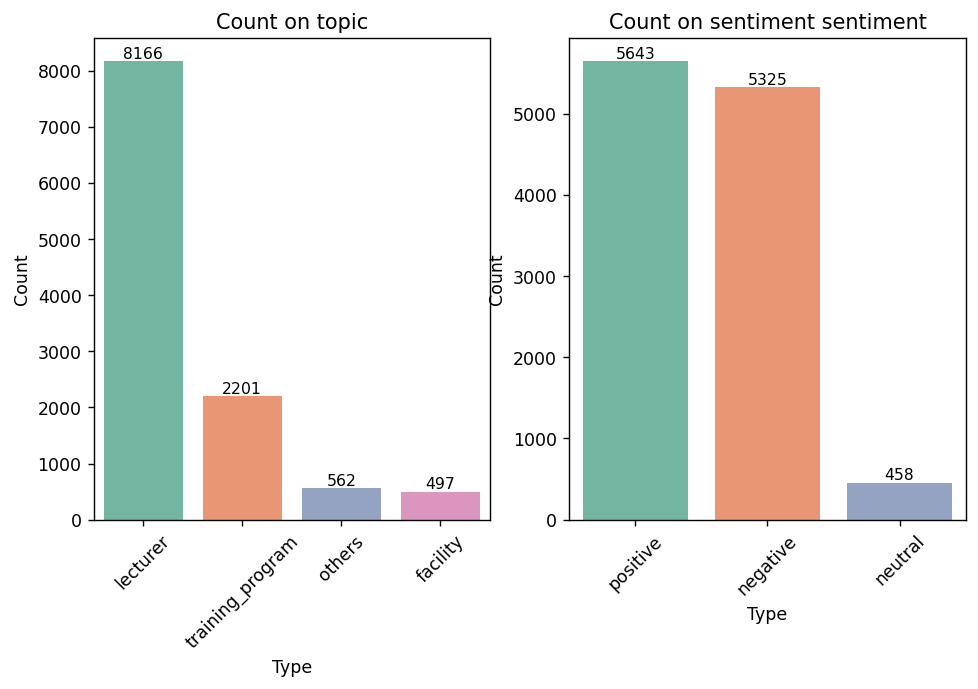

In [6]:
visualize(train, 'topic', 'sentiment')

Dev

<ipython-input-5-8506a5c4b228>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax[0], data=data, x=col1, order=train[col1].value_counts().index, palette='Set2')
<ipython-input-5-8506a5c4b228>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax[1], data=data, x=col2, order=data[col2].value_counts().index, palette='Set2')


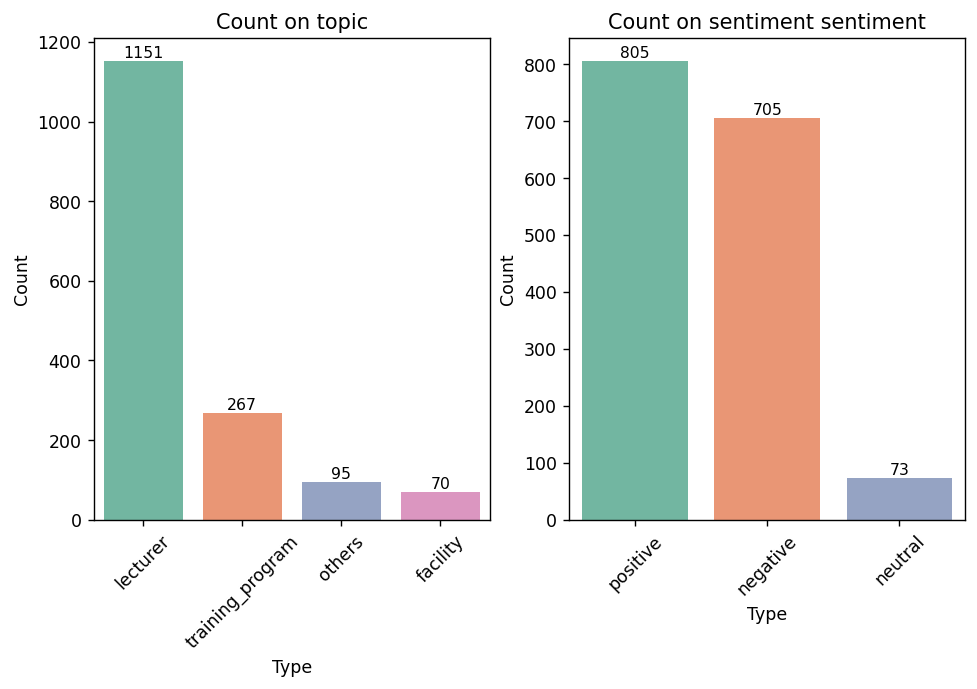

In [7]:
visualize(dev, 'topic', 'sentiment')

Test

<ipython-input-5-8506a5c4b228>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax[0], data=data, x=col1, order=train[col1].value_counts().index, palette='Set2')
<ipython-input-5-8506a5c4b228>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax[1], data=data, x=col2, order=data[col2].value_counts().index, palette='Set2')


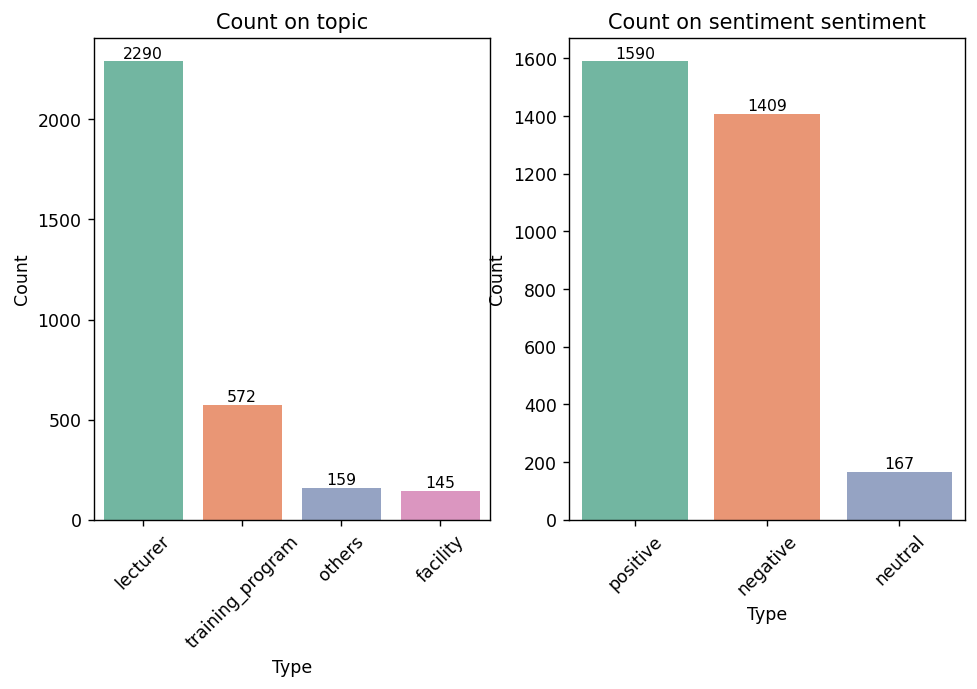

In [8]:
visualize(test, 'topic', 'sentiment')

Standardize

In [9]:
def clean(text):
    text = re.sub(r"[.,?\-]", "", text)
    text = re.sub(r"\s+", " ", text)

    return text

In [10]:
train['sentence'] = train['sentence'].apply(clean)
dev['sentence'] = dev['sentence'].apply(clean)
test['sentence'] = test['sentence'].apply(clean)

#Loading model

Source: https://github.com/VinAIResearch/PhoBERT

In [11]:
def loading_model():
  phobert = AutoModel.from_pretrained("vinai/phobert-base")
  tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
  return phobert, tokenizer

In [12]:
model, tokenizer = loading_model()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

# Word Segmentation
Use VnCoreNLP: https://github.com/vncorenlp/VnCoreNLP

Installation: https://viblo.asia/p/bert-roberta-phobert-bertweet-ung-dung-state-of-the-art-pre-trained-model-cho-bai-toan-phan-loai-van-ban-4P856PEWZY3#_phobert-la-gi-the-qua-la-sen-0

In [13]:
!pip install vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=67c58689608c5cb2501c52f71b3f36fdfa9f32b3f9cece3b448c708b26cca206
  Stored in directory: /root/.cache/pip/wheels/80/ad/d4/9e1a0939f63331a3898f2a951a368bbf0d69f7b027cae4d66b
Successfully built vncorenlp


In [14]:
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/VnCoreNLP"
!wget -P "/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/VnCoreNLP" https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget -P "/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/VnCoreNLP/models/wordsegmenter" https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget -P "/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/VnCoreNLP/models/wordsegmenter" https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr

--2025-05-28 12:25:45--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/VnCoreNLP/VnCoreNLP-1.1.1.jar.1’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  48.2MB/s    in 0.5s    

2025-05-28 12:25:46 (48.2 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/VnCoreNLP/VnCoreNLP-1.1.1.jar.1’ saved [27412575/27412575]

--2025-05-28 12:25:47--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting t

In [15]:
from vncorenlp import VnCoreNLP

segmenter = VnCoreNLP("/content/drive/MyDrive/Colab Notebooks/DS102/Lab5/VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

# text = "nội dung môn học có phần thiếu trọng tâm , hầu như là chung chung , khái quát khiến sinh viên rất khó nắm được nội dung môn học ."

# word_segmented_text = segmenter.tokenize(text)
# print(word_segmented_text)

In [16]:
def segmented_sentence(data, sentence):
    segmented = segmenter.tokenize(sentence)
    words = [word for sent in segmented for word in sent]

    return words

def segment_data(data, text):
    embeddings = []
    for sent in tqdm(data[text]):
        vec = segmented_sentence(data, sent)
        embeddings.append(vec)

    return embeddings

In [17]:
train_seg = segment_data(train, 'sentence')
test_seg = segment_data(test, 'sentence')
dev_seg = segment_data(dev, 'sentence')

100%|██████████| 1583/1583 [00:06<00:00, 241.98it/s]


In [18]:
train_seg[11110]

['cô_giáo', 'dễ_thương', 'dạy', 'dễ', 'hiểu']

# PhoBERT Semantic Extraction

In [19]:
def make_PhoBERT_features(text, batch_size, max_len):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_features = []

    for i in range(0, len(text), batch_size):
        batch = text[i:i + batch_size]
        v_tokenized = []

        for i_text in batch:
            line = " ".join(i_text)
            encoded = tokenizer.encode(line)
            v_tokenized.append(encoded)

        # Padding
        padded = np.array([
            i + [1] * (max_len - len(i)) if len(i) < max_len else i[:max_len]
            for i in v_tokenized
        ])
        attention_mask = np.where(padded == 1, 0, 1)

        # Convert to tensor
        input_ids = torch.tensor(padded).to(torch.long).to(device)
        attention_mask = torch.tensor(attention_mask).to(torch.long).to(device)

        # Get CLS embeddings
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_features = outputs[0][:, 0, :]
            all_features.append(cls_features.cpu().numpy())

    return np.vstack(all_features)

In [20]:
train_emb = make_PhoBERT_features(train_seg, 32, 100)
test_emb = make_PhoBERT_features(test_seg, 32, 100)
dev_emb = make_PhoBERT_features(dev_seg, 32, 100)

Extracting embeddings: 100%|██████████| 50/50 [00:08<00:00,  5.63it/s]


# GMM

### Encoding

In [21]:
def label_encode(df):
    # Unique labels
    topic_labels = df['topic'].unique()
    sentiment_labels = df['sentiment'].unique()

    # Mapping Dictionary
    topic = {label: idx for idx, label in enumerate(topic_labels)}
    sentiment = {label: i for i, label in enumerate(sentiment_labels)}

    # Encode
    topic_encoded = np.array([topic[label] for label in df['topic']])
    sentiment_encoded = np.array([sentiment[label] for label in df['sentiment']])

    return topic_encoded, sentiment_encoded

In [22]:
topic_train, sentiment_train = label_encode(train)
topic_test, sentiment_test = label_encode(test)
topic_dev, sentiment_dev = label_encode(dev)

In [23]:
train_emb.shape

(11426, 768)

In [24]:
topic_train.shape

(11426,)

In [25]:
topic_train = topic_train.reshape(-1, 1)
topic_dev = topic_dev.reshape(-1, 1)
topic_test = topic_test.reshape(-1, 1)

X_train = np.concat([train_emb, topic_train], axis=1)
X_test = np.concat([test_emb, topic_test], axis=1)
X_dev = np.concat([dev_emb, topic_dev], axis=1)

y_train = sentiment_train
y_test = sentiment_test
y_dev = sentiment_dev

### Model

In [31]:
class GMM:
    def __init__(self, k=None, max_iter=None, reg_covar=1e-6):
        self.k = k
        self.max_iter = max_iter
        self.reg_covar = reg_covar

    def initialize(self, X):
        self.n, self.m = X.shape
        self.phi = np.ones(self.k) / self.k
        random_rows = np.random.choice(self.n, self.k, replace=False)
        self.means_ = np.array([X[i] for i in random_rows])
        self.covariances_ = np.array([
            np.cov(X.T, bias=True) + self.reg_covar * np.eye(self.m)
            for _ in range(self.k)
        ])

    def predict_proba(self, X):
        n = X.shape[0]
        log_likelihood = np.zeros((n, self.k))
        for i in range(self.k):
            diff = X - self.means_[i]
            inv_cov = np.linalg.inv(self.covariances_[i])
            det_cov = np.linalg.det(self.covariances_[i])
            log_det = np.log(det_cov + 1e-10)
            exponent = -0.5 * np.sum((diff @ inv_cov) * diff, axis=1)
            log_likelihood[:, i] = -0.5 * (self.m * np.log(2 * np.pi) + log_det) + exponent

        log_likelihood += np.log(self.phi + 1e-10)
        log_likelihood -= np.max(log_likelihood, axis=1, keepdims=True)
        proba = np.exp(log_likelihood)
        return proba / np.sum(proba, axis=1, keepdims=True)

    def e_step(self, X):
        self.resp_ = self.predict_proba(X)

    def m_step(self, X):
        Nk = self.resp_.sum(axis=0)
        self.phi = Nk / X.shape[0]

        for i in range(self.k):
            resp_i = self.resp_[:, i].reshape(-1, 1)
            total_resp = Nk[i]
            self.means_[i] = (resp_i * X).sum(axis=0) / total_resp
            diff = X - self.means_[i]
            cov = (resp_i * diff).T @ diff / total_resp
            self.covariances_[i] = cov + self.reg_covar * np.eye(self.m)

    def fit(self, X, X_dev, y_dev):
        self.initialize(X)
        for epoch in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            y_pred = self.predict(X_dev)
            acc = self.compute_accuracy(y_dev, y_pred)
            print(f"Epoch {epoch+1}/{self.max_iter}, Accuracy: {acc:.4f}")

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def compute_accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

### Training

In [32]:
def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    precision = 0
    recall = 0
    f1_macro = 0

    k = model.k
    precision = np.zeros(k)
    recall = np.zeros(k)
    f1 = np.zeros(k)

    for i in range(k):
        true_positives = np.sum((y_true == i) & (y_pred == i))
        false_positives = np.sum((y_true != i) & (y_pred == i))
        false_negatives = np.sum((y_true == i) & (y_pred != i))

        precision[i] = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall[i] = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    precision = np.mean(precision)
    recall = np.mean(recall)
    f1_macro = np.mean(f1)

    print(f"Precision = {precision:.4f}")
    print(f"Recall = {recall:.4f}")
    print(f"F1 = {f1_macro:.4f}")

In [37]:
gmm = GMM(k=3, max_iter=20)
gmm.fit(X_train, X_dev, y_dev)

Epoch 1/20, Accuracy: 0.5085
Epoch 2/20, Accuracy: 0.5085
Epoch 3/20, Accuracy: 0.5085
Epoch 4/20, Accuracy: 0.5085
Epoch 5/20, Accuracy: 0.5085
Epoch 6/20, Accuracy: 0.5085
Epoch 7/20, Accuracy: 0.5085
Epoch 8/20, Accuracy: 0.5085
Epoch 9/20, Accuracy: 0.5085
Epoch 10/20, Accuracy: 0.5085
Epoch 11/20, Accuracy: 0.5085
Epoch 12/20, Accuracy: 0.5085
Epoch 13/20, Accuracy: 0.5085
Epoch 14/20, Accuracy: 0.5085
Epoch 15/20, Accuracy: 0.5085
Epoch 16/20, Accuracy: 0.5085
Epoch 17/20, Accuracy: 0.5085
Epoch 18/20, Accuracy: 0.5085
Epoch 19/20, Accuracy: 0.5085
Epoch 20/20, Accuracy: 0.5085


In [38]:
print("Evaluation: ")
evaluate(gmm, X_test, y_test)

Evaluation: 
Precision = 0.1483
Recall = 0.3333
F1 = 0.2053
